<a href="https://colab.research.google.com/github/Muhirwakyeyune/Deep-RL/blob/main/Traffic_light_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Members of the group:
Khady Gaye,
Mame Diarra Diouf,
Honorine Gnonfin,
Mame Diarra Diop,
Salomon Muhirwa.

In [ ]:
#@title Installations  { form-width: "30%" }

%pip install git+https://github.com/deepmind/acme.git#egg=dm-acme[jax,tf,envs]

from IPython.display import clear_output
clear_output()

In [ ]:
import IPython
import base64
import chex
import collections
from collections import namedtuple
import enum
import functools
import gym
import haiku as hk
import io
import itertools
import jax
from jax import tree_util
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import reverb
import rlax
import time
from typing import Callable
import tree

# Filter out warnings as they are distracting.
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=3, suppress=1)

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/reverb/platform/default/ensure_tf_install.py:53: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(version) <
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [ ]:
import random

In [ ]:
class SingleIntersectionEnv:
  def __init__(self, seed = 42):
    self.number_action = 2 # (0,1) where 0 means continue with the current light and 1 means change the light
    self.state = np.array([0,0])
    self.light_configuration = 1 #  1 means red light for flow1 and green for flow2 and 0 means green light for flow1 and red for flow2

  def init(self):
    self.state = np.array([0,0])
    return SingleIntersectionEnv()

  def step(self, action):
    # choose randomly a number of vehicles coming to the intersection from road 1
    c1 = random.choices([0,1],weights = [3/4, 1/4], k=1)[0]
    # choose randomly a number of vehicles coming to the intersection from road 2
    c2 = random.choices([0,1],weights = [3/4, 1/4], k=1)[0]
    self.state[0] = self.state[0] + c1
    self.state[1] = self.state[1] + c2
    obs = self.observation()
    L = (action + self.light_configuration)%2
    self.light_configuration = L
    if self.light_configuration == 0:
      d1 = min(1, self.state[0])
      temp1 = self.state[0] - d1
      self.state[0] = temp1
    else:
      d2 = min(1, self.state[1])
      temp2 = self.state[1] - d2
      self.state[1] = temp2
    return SingleIntersectionEnv()


  def observation(self):
    obs = np.array([self.state[0], self.state[1], self.light_configuration])
    return obs

  def reward(self):
    obs = self.observation()
    r = - np.sum(self.state**2) #(obs[0]**2 + obs[1]**2)
    return r


In [ ]:
env = SingleIntersectionEnv()

In [ ]:
import dataclasses

@chex.dataclass
class Transition:
  observation: chex.Array
  action: chex.Array
  reward: chex.Array
  done: chex.Array
  next_observation: chex.Array


class ReplayBuffer:
  """Fixed-size buffer to store transition tuples."""

  def __init__(self, buffer_capacity: int):
      """Initialize a ReplayBuffer object.
      Args:
          buffer_capacity (int): maximum allowed size of the replay buffer.
      """
      self._memory = list()
      self._maxlen = buffer_capacity

  @property
  def size(self) -> int:
    # Return the current number of elements in the buffer.
    return len(self._memory)

  def add(self, transition: Transition) -> None:
      """Add a new transition to memory."""
      if self.size >= self._maxlen:
        self._memory.pop(0)
      self._memory.append(transition)

  def sample(self) -> Transition:
      """Randomly sample a transition from memory."""
      assert self._memory, 'replay buffer is unfilled'
      return random.choice(self._memory)

  def sample_batch(self, batch_size: int) -> Transition:
    """Randomly sample a batch of experiences from memory."""
    assert len(self._memory) >= batch_size, 'Insuficient number of transitions in replay buffer'
    transitions: list[Transition] = random.choices(self._memory, k=batch_size)
    return tree.map_structure(lambda *x: np.stack(x), *transitions)


In [ ]:
def q_network(x: chex.Array):
  out = x
  out = hk.Linear(128)(out)
  out = jax.nn.relu(out)
  out = hk.Linear(128)(out)
  out = jax.nn.relu(out)
  out = hk.Linear(2)(out)
  return out

In [ ]:
# A convenient way to pack together all the variables we need when updating
# the agent.
@chex.dataclass
class LearnerState:
  online_params: hk.Params
  target_params: hk.Params
  opt_state: optax.OptState

class DQNAgent:

  def __init__(
      self,
      init_params_fn: Callable[[jax.random.KeyArray], hk.Params],
      network_apply_fn: Callable[[hk.Params, chex.Array], chex.Array],
      optimizer: optax.GradientTransformation,
      gamma: float,
      epsilon: float,
      num_actions: int,
      buffer_capacity: int,
      batch_size: int,
      target_ema: float,
      seed: int = 0,
  ) -> None:
    """Initializes the DQN agent.

    Args:
      init_params_fn: the pure function which initializes the network parameters.
      network_apply_fn: the pure function corresponding to the desired DQN network.
      optimizer: the optimizer used to minimize the DQN loss.
      gamma: the agent's discount factor.
      epsilon: probability to perform a random exploration when picking a new action.
      num_actions: number of actions in the environment's action space.
      buffer_capacity: capacity of the replay buffer.
      batch_size: batch size when updating the online network.
      target_ema: exponential moving average weight for updating the target network params.
      seed: seed of the random generator.
    """
    self._gamma = gamma
    self._epsilon = epsilon
    self._num_actions = num_actions
    self._batch_size = batch_size
    self._target_ema = target_ema

    # Set the neural network and optimizer.
    self._network_apply_fn = network_apply_fn
    self._optimizer = optimizer

    # Initialize the replay buffer.
    self._buffer = ReplayBuffer(buffer_capacity)

    # Always store the current observation so we can create transitions.
    self._observation = None

    # Initialize the network's parameters.
    params = init_params_fn(jax.random.PRNGKey(seed))

    # Initialize the learner state.
    self._learner_state = LearnerState(
        online_params=params,
        target_params=jax.tree_map(jnp.copy, params),
        opt_state=self._optimizer.init(params),
    )

    # JIT the update step.
    self._update = jax.jit(self._update_fn)

  def observe_first(self, observation: chex.Array) -> None:
    self._observation = observation

  def select_action(
      self,
      observation: chex.Array,
      eval: bool,
  ) -> chex.Array:
    """Picks the next action using an epsilon greedy policy.

    Args:
      obersation: observed state of the environment.
      eval: if True the agent is acting in evaluation mode (which means it only
        acts according to the best policy it knows.)
    """
    # Choose action using an epsilon-greedy policy.
    if eval or np.random.uniform() > self._epsilon:
      # Greedy action selection.
      q_values = self._network_apply_fn(
          self._learner_state.online_params,
          observation
      )
      action = jnp.argmax(q_values)
    else:
      # Random action selection.
      action = np.random.randint(self._num_actions)

    return action

  def _loss_fn(
      self,
      online_params: hk.Params,
      target_params: hk.Params,
      transition: Transition,
  ) -> chex.Array:
      """Computes the Q-learning loss

      Args:
        online_params: parameters of the online network.
        target_params: parameters of the target network.
        transition: container of transition quantities (s, a, r, done, s')
      Returns:
        The Q-learning loss.
      """
      target_q_values = self._network_apply_fn(
          target_params,
          transition.next_observation,
      )
      y = transition.reward + self._gamma * jnp.max(target_q_values, axis=-1)
      online_q_values = self._network_apply_fn(
          online_params,
          transition.observation,
      )
      get_value_at_action_t = jax.vmap(lambda q, a: q[a])
      online_q_value_at_action_t = get_value_at_action_t(
          online_q_values,
          transition.action
      )
      loss = jnp.mean(
          jnp.square(y - online_q_value_at_action_t)
      )

      return loss

  def _update_fn(
      self,
      state: LearnerState,
      batch: Transition,
  ) -> tuple[LearnerState, chex.Array]:
    """Get the next learner state given the current batch of transitions.

    Args:
      state: the current learner state.
      batch: batch of transitions (st, at, rt, done_t, stp1)
    Returns:
      A tuple of:
        - the updated learner state, and
        - the loss incurred by the previous learner state given the batch.
    """

    # Compute gradients
    loss, grad = jax.value_and_grad(self._loss_fn)(
        state.online_params,
        target_params=state.target_params,
        transition=batch
    )
    # Apply gradients
    updates, opt_state = self._optimizer.update(grad, state.opt_state)
    online_params = optax.apply_updates(state.online_params, updates)

    # Update target network params as:
    # target_params <- ema * target_params + (1 - ema) * online_params
    ema = self._target_ema
    target_params = jax.tree_map(
        lambda online, target: ema * target + (1 - ema) * online,
        online_params,
        state.target_params,
    )

    next_state = LearnerState(
      online_params=online_params,
      target_params=target_params,
      opt_state=opt_state,
    )

    return next_state, loss

  def observe(self, action: chex.Array, timestep: SingleIntersectionEnv) -> None:
    """Updates the agent from the given observations.

    Args:
      action: action performed at time t.
      timestep: timestep returned by the environment after
    """
    # Create the transition.
    transition = Transition(
        # Current observation.
        observation=self._observation,
        # Action taken given that observation.
        action=action,
        # Result of taking the action.
        reward=timestep.reward(),
        done= 0,
        next_observation=timestep.observation(),
    )
    # Add the transition to the replay buffer.
    self._buffer.add(transition)
    # Update the current observation.
    self._observation = timestep.observation()

  def update(self) -> chex.Array | None:
    """Performs an update step if there is enough transitions in the buffer.

    Returns: DQN loss obtained when updating the online network or None if
      there was not enough data.
    """
    if self._buffer.size >= self._batch_size:
      batch = self._buffer.sample_batch(self._batch_size)
      self._learner_state, loss = self._update(self._learner_state, batch)
      return loss
    return None

In [ ]:
# Create the network pure functions.
dqn_network = hk.without_apply_rng(hk.transform(q_network))

# Bind a dummy observation to the init function so the agent doesn't have to.
observation_spec = env.observation()
dummy_observation = np.zeros(observation_spec.shape, jnp.float32)
print(dummy_observation)
init_params_fn = lambda rng: dqn_network.init(rng, dummy_observation)

# Create the optimizer.
optimizer = optax.adam(learning_rate=0.001)

dqn_agent = DQNAgent(
    init_params_fn=init_params_fn,
    network_apply_fn=dqn_network.apply,
    optimizer=optimizer,
    gamma=.99,
    epsilon=.9,
    num_actions=2,
    buffer_capacity=2000,
    batch_size=32,
    target_ema=.9,
)
jax.tree_map(lambda x: x.shape, dqn_agent._learner_state)

[0. 0. 0.]


LearnerState(online_params={'linear': {'b': (128,), 'w': (3, 128)}, 'linear_1': {'b': (128,), 'w': (128, 128)}, 'linear_2': {'b': (2,), 'w': (128, 2)}}, target_params={'linear': {'b': (128,), 'w': (3, 128)}, 'linear_1': {'b': (128,), 'w': (128, 128)}, 'linear_2': {'b': (2,), 'w': (128, 2)}}, opt_state=(ScaleByAdamState(count=(), mu={'linear': {'b': (128,), 'w': (3, 128)}, 'linear_1': {'b': (128,), 'w': (128, 128)}, 'linear_2': {'b': (2,), 'w': (128, 2)}}, nu={'linear': {'b': (128,), 'w': (3, 128)}, 'linear_1': {'b': (128,), 'w': (128, 128)}, 'linear_2': {'b': (2,), 'w': (128, 2)}}), EmptyState()))

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	-36.5
	10	|	-6.4
	20	|	-4.2
	30	|	-41.6
	40	|	-41.6
	50	|	-4.5
	60	|	-34.0
	70	|	-39.9
	80	|	-34.3
	90	|	-4.0
	100	|	-43.4
	110	|	-32.5
	120	|	-28.2
	130	|	-4.5
	140	|	-21.6
	150	|	-7.0
	160	|	-4.5
	170	|	-4.8
	180	|	-20.7
	190	|	-54.3
	200	|	-35.4
	210	|	-6.1
	220	|	-25.7
	230	|	-3.7
	240	|	-45.4
	250	|	-48.6
	260	|	-4.4
	270	|	-28.9
	280	|	-3.8
	290	|	-46.5
	300	|	-4.0
	310	|	-38.4
	320	|	-38.1
	330	|	-45.9
	340	|	-27.6
	350	|	-51.7
	360	|	-31.9
	370	|	-7.1
	380	|	-4.2
	390	|	-21.6
	400	|	-40.9
	410	|	-4.2
	420	|	-45.8
	430	|	-4.4
	440	|	-31.4
	450	|	-52.3
	460	|	-25.1
	470	|	-3.4
	480	|	-2.5
	490	|	-22.7
	500	|	-21.5
	510	|	-45.0
	520	|	-3.8
	530	|	-39.0
	540	|	-38.1
	550	|	-3.5
	560	|	-36.6
	570	|	-4.1
	580	|	-56.2
	590	|	-2.6
	600	|	-3.6
	610	|	-4.9
	620	|	-3.6
	630	|	-5.1
	640	|	-1.5
	650	|	-6.3
	660	|	-36.2
	670	|	-37.8
	680	|	-3.1
	690	|	-22.4
	700	|	-25.1
	710	|	-5

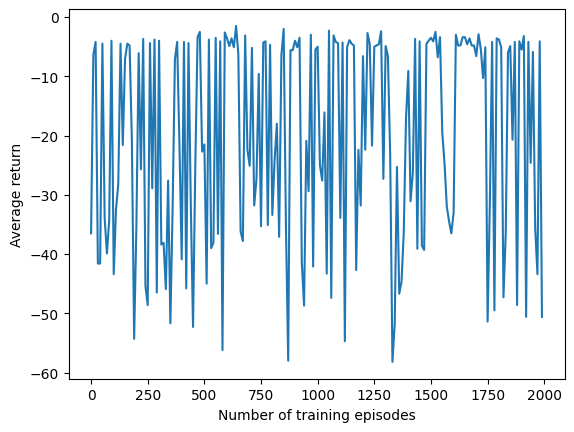

In [ ]:
num_episodes = 2000
num_eval_episodes = 10
eval_every_period = 10

dqn_agent = DQNAgent(
    init_params_fn=init_params_fn,
    network_apply_fn=dqn_network.apply,
    optimizer=optimizer,
    gamma=.9,
    epsilon=.1,
    num_actions=2,
    buffer_capacity=2000,
    batch_size=32,
    target_ema=.9,
)
def run_dqn_episode(
    dqn_agent: DQNAgent,
    env: SingleIntersectionEnv(),
    eval: bool,
) -> float:
  """Runs a single episode of catch.

  Args:
    dqn_agent: agent to train or evaluate
    env: the Catch environment the agent should interact with.
    eval: evaluation mode.
  Returns:
    The total reward accumulated over the episode.
  """
  # Reset any counts and start the environment.
  timestep = env.init()
  # env.init()
  dqn_agent.observe_first(timestep.observation())
  total_reward = 0
  t = 0
  # Run an episode.
  while t!= 10:

    # Generate an action from the agent's policy and step the environment.
    action = dqn_agent.select_action(timestep.observation(), eval)
    timestep = env.step(action)

    # If the agent is training (not eval), add the transition to the replay
    # buffer and do an update step.
    if not eval:
      dqn_agent.observe(action, timestep.step(action))
      dqn_agent.update()
    r = env.reward()

    total_reward += r
    t+=1
  return total_reward

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

# Initialize logged quantities.
episodes = []
all_rewards = []
env = SingleIntersectionEnv()
for episode in range(num_episodes):
  # Run a training episode.
  run_dqn_episode(
      dqn_agent,
      env,
      eval=False
  )
  # Every once in a while, evaluate the greedy policy on a few episodes.
  if episode % eval_every_period == 0:
    reward = np.mean([
        run_dqn_episode(dqn_agent, env, eval = True)
        for _ in range(num_eval_episodes)
    ])
    # Print how much reward the agent accumulated on average.
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

In [ ]:
class DDQNAgent:

  def __init__(
      self,
      init_params_fn: Callable[[jax.random.KeyArray], hk.Params],
      network_apply_fn: Callable[[hk.Params, chex.Array], chex.Array],
      optimizer: optax.GradientTransformation,
      gamma: float,
      epsilon: float,
      num_actions: int,
      buffer_capacity: int,
      batch_size: int,
      target_ema: float,
      seed: int = 0,
  ) -> None:
    """Initializes the DQN agent.

    Args:
      init_params_fn: the pure function which initializes the network parameters.
      network_apply_fn: the pure function corresponding to the desired DQN network.
      optimizer: the optimizer used to minimize the DQN loss.
      gamma: the agent's discount factor.
      epsilon: probability to perform a random exploration when picking a new action.
      num_actions: number of actions in the environment's action space.
      buffer_capacity: capacity of the replay buffer.
      batch_size: batch size when updating the online network.
      target_ema: exponential moving average weight for updating the target network params.
      seed: seed of the random generator.
    """
    self._gamma = gamma
    self._epsilon = epsilon
    self._num_actions = num_actions
    self._batch_size = batch_size
    self._target_ema = target_ema

    # Set the neural network and optimizer.
    self._network_apply_fn = network_apply_fn
    self._optimizer = optimizer

    # Initialize the replay buffer.
    self._buffer = ReplayBuffer(buffer_capacity)

    # Always store the current observation so we can create transitions.
    self._observation = None

    # Initialize the network's parameters.
    params = init_params_fn(jax.random.PRNGKey(seed))

    # Initialize the learner state.
    # self._learner_state = ...  # Your code here !
    self._learner_state = LearnerState(
        online_params=params,
        target_params=jax.tree_map(jnp.copy, params),
        opt_state=self._optimizer.init(params),
    )

    # JIT the update step.
    self._update = jax.jit(self._update_fn)

  def observe_first(self, observation: chex.Array) -> None:
    self._observation = observation

  def select_action(
      self,
      observation: chex.Array,
      eval: bool,
  ) -> chex.Array:
    """Picks the next action using an epsilon greedy policy.

    Args:
      obersation: observed state of the environment.
      eval: if True the agent is acting in evaluation mode (which means it only
        acts according to the best policy it knows.)
    """
    # Choose action using an epsilon-greedy policy
    if eval or np.random.uniform() > self._epsilon:
      # Greedy action selection.
      q_values = self._network_apply_fn(
          self._learner_state.online_params,
          observation
      )
      action = jnp.argmax(q_values)
    else:
      # Random action selection.
      action = np.random.randint(self._num_actions)

    return action

  def _loss_fn(
    self,
    online_params: hk.Params,
    target_params: hk.Params,
    transition: Transition,
) -> chex.Array:
    """Computes the DDQN loss.

    Args:
      online_params: Parameters of the online network.
      target_params: Parameters of the target network.
      transition: Container of transition quantities (s, a, r, done, s')
    Returns:
      The DDQN loss.
    """
    # Compute the action selected by the online network.
    online_q_values = self._network_apply_fn(
        online_params,
        transition.next_observation,
    )
    online_selected_action = jnp.argmax(online_q_values, axis=-1) # [[],[]]

    # Use the target network to evaluate the selected action.
    print(list(transition.next_observation[0]))
    target_q_values = self._network_apply_fn(
        target_params,
        transition.next_observation,
    )
    # print(online_selected_action)
    target_action_value = jnp.take_along_axis(
        target_q_values,online_selected_action[:,None], axis=-1)

    # Compute the target value.
    target=jnp.where(
        transition.done,
        transition.reward,
        transition.reward + self._gamma * target_action_value,
    )

    # Compute the Q-learning loss.
    online_q_values = self._network_apply_fn(
        online_params,
        transition.observation,
    )
    online_action_value = online_q_values[transition.action]
    get_value_at_action_t = jax.vmap(lambda q, a: q[a])
      #get_value_at_action_t =
    online_q_value_at_action_t = get_value_at_action_t(
        online_action_value,
        transition.action
    )

    loss = 0.5 * jnp.mean(
        jnp.square(target - online_q_value_at_action_t)
        )

    return loss


  def _update_fn(
    self,
    state: LearnerState,
    batch: Transition,
) -> tuple[LearnerState, chex.Array]:
    """Get the next learner state given the current batch of transitions.

    Args:
      state: The current learner state.
      batch: Batch of transitions (st, at, rt, done_t, stp1)
    Returns:
      A tuple of:
        - The updated learner state, and
        - The loss incurred by the previous learner state given the batch.
    """
    # Compute gradients.
    loss, grad = jax.value_and_grad(self._loss_fn)(
        state.online_params,
        target_params=state.target_params,
        transition=batch,
    )
    print("\n\ngrad: ",grad)


    # Apply gradients.
    updates, opt_state = self._optimizer.update(grad, state.opt_state)
    online_params = optax.apply_updates(state.online_params, updates)

    # Update target network params with EMA.
    ema = self._target_ema
    print(ema)
    target_params = jax.tree_map(
        lambda online, target: ema * target + (1 - ema) * online,
        online_params,
        state.target_params,
    )

    next_state = LearnerState(
        online_params=online_params,
        target_params=target_params,
        opt_state=opt_state,
    )


    return next_state, loss


  def observe(self, action: chex.Array, timestep: SingleIntersectionEnv) -> None:
    """Updates the agent from the given observations.

    Args:
      action: action performed at time t.
      timestep: timestep returned by the environment after
    """
    # Create the transition.
    transition = Transition(
        # Current observation.
        observation=self._observation,
        # Action taken given that observation.
        action=action,
        # Result of taking the action.
        reward=timestep.reward(),
        done= 0,
        next_observation=timestep.observation(),
    )
    # Add the transition to the replay buffer.
    self._buffer.add(transition)
    # Update the current observation.
    self._observation = timestep.observation()

  def update(self) -> chex.Array | None:
    """Performs an update step if there is enough transitions in the buffer.

    Returns: DQN loss obtained when updating the online network or None if
      there was not enough data.
    """
    if self._buffer.size >= self._batch_size:
      batch = self._buffer.sample_batch(self._batch_size)
      self._learner_state, loss = self._update(self._learner_state, batch)
      return loss
    return None

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	-36.2
[Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>]


grad:  {'linear': {'b': Traced<ShapedArray(float32[128])>with<DynamicJaxprTrace(level=0/1)>, 'w': Traced<ShapedArray(float32[3,128])>with<DynamicJaxprTrace(level=0/1)>}, 'linear_1': {'b': Traced<ShapedArray(float32[128])>with<DynamicJaxprTrace(level=0/1)>, 'w': Traced<ShapedArray(float32[128,128])>with<DynamicJaxprTrace(level=0/1)>}, 'linear_2': {'b': Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=0/1)>, 'w': Traced<ShapedArray(float32[128,2])>with<DynamicJaxprTrace(level=0/1)>}}
0.9
	10	|	-5.6
	20	|	-6.2
	30	|	-34.4
	40	|	-36.1
	50	|	-40.0
	60	|	-3.1
	70	|	-11.8
	80	|	-3.2
	90	|	-22.3
	100	|	-22.0
	110	|	-5.7
	120	|	-4.1
	130	|	-2.8
	140	|	-3.1
	150	|	-4.5
	160	|

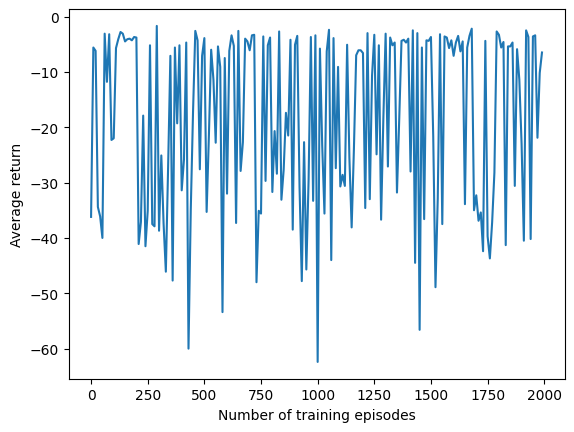

In [ ]:
num_episodes = 2000
num_eval_episodes = 10
eval_every_period = 10

ddqn_agent = DDQNAgent(
    init_params_fn=init_params_fn,
    network_apply_fn=dqn_network.apply,
    optimizer=optimizer,
    gamma=.9,
    epsilon=.1,
    num_actions=2,
    buffer_capacity=2000,
    batch_size=32,
    target_ema=.9,
)
def run_ddqn_episode(
    ddqn_agent: DDQNAgent,
    env: SingleIntersectionEnv(),
    eval: bool,
) -> float:
  """Runs a single episode of catch.

  Args:
    dqn_agent: agent to train or evaluate
    env: the Catch environment the agent should interact with.
    eval: evaluation mode.
  Returns:
    The total reward accumulated over the episode.
  """
  # Reset any counts and start the environment.
  timestep = env.init()
  # env.init()
  ddqn_agent.observe_first(timestep.observation())
  total_reward = 0
  t = 0
  # Run an episode.
  while t!= 10:

    # Generate an action from the agent's policy and step the environment.
    action = ddqn_agent.select_action(timestep.observation(), eval)
    timestep = env.step(action)

    # If the agent is training (not eval), add the transition to the replay
    # buffer and do an update step.
    if not eval:
      ddqn_agent.observe(action, timestep.step(action))
      ddqn_agent.update()
    r = env.reward()

    total_reward += r
    t+=1
  return total_reward

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

# Initialize logged quantities.
episodes = []
all_rewards = []
env = SingleIntersectionEnv()
for episode in range(num_episodes):
  # Run a training episode.
  run_ddqn_episode(
      ddqn_agent,
      env,
      eval=False
  )
  # Every once in a while, evaluate the greedy policy on a few episodes.
  if episode % eval_every_period == 0:
    reward = np.mean([
        run_ddqn_episode(ddqn_agent, env, eval = True)
        for _ in range(num_eval_episodes)
    ])
    # Print how much reward the agent accumulated on average.
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)